# Part 2: Training an ML Model

This part of the MLRun getting-started tutorial walks you through the steps for training a machine-learning (ML) model, including data exploration and model testing.

The tutorial consists of the following steps:

1. [Setup and Configuration](#gs-tutorial-2-step-setup)
2. [Creating a training function](#gs-tutorial-2-step-create-a-training-function)
3. [Exploring the data with an MLRun marketplace function](#gs-tutorial-2-step-explore-data-w-mlrun-func)
4. [Testing your model](#gs-tutorial-2-step-test-model)

By the end of this tutorial you'll learn how to

- Create a training function, store models, and track experiments while running them.
- Use artifacts as inputs to functions.
- Leverage the MLRun functions marketplace.
- View plot artifacts.

<a id="gs-tutorial-2-prerequisites"></a>

## Prerequisites

The following steps are a continuation of the previous part of this getting-started tutorial and rely on the generated outputs.
Therefore, make sure to first run [part 1](01-mlrun-basics.ipynb) of the tutorial.

<a id="gs-tutorial-2-step-setup"></a>

## Step 1: Setup and Configuration

<a id="gs-tutorial-2-mlrun-import-libraries"></a>

### Importing Libraries

Run the following code to import required libraries:

In [2]:
from os import path
import mlrun

<a id="gs-tutorial-2-mlrun-envr-init"></a>

### Initializing Your MLRun Environment

Use the `set_environment` MLRun method to configure the working environment and default configuration.
Set the `project` and `user_project` parameters to the same values that you used in the call to this method in the [Part 1: MLRun Basics](./01-mlrun-basics.ipynb#gs-tutorial-1-set-mlrun-envr) tutorial notebook.

In [3]:
# Set the base project name
project_name_base = 'getting-started-tutorial'
# Initialize the MLRun environment and save the project name and artifacts path
project_name, artifact_path = mlrun.set_environment(project=project_name_base,
                                                    user_project=True)

<a id="gs-tutorial-2-mark-mlrun-code-start"></a>

### Marking The Beginning of Your Function Code

The following code uses the `# nuclio: start-code` marker comment annotation to instruct MLRun to start processing code only from this location.

> **Note:** You can add code to define function dependencies and perform additional configuration after the `# nuclio: start-code` marker and before [the `# nuclio: end-code` marker](#gs-tutorial-2-mark-mlrun-code-end).

In [4]:
# nuclio: start-code

<a id="gs-tutorial-2-step-create-a-training-function"></a>

## Step 2: Creating a Training Function

An essential component of artifact management and versioning is storing a model version.
This allows users to experiment with different models and compare their performance without having to worry about losing previous results.

The simplest way to store a model named `my_model`, for example, is with the following code:

``` python
from cloudpickle import dumps
model_data = dumps(model)
context.log_model(key='my_model', body=model_data, model_file='my_model.pkl')
```

You can also store any related metrics by providing a dictionary in the `metrics` parameter, such as `metrics={'accuracy': 0.9}`.
Furthermore, you can use the `extra_data` parameter to pass any additional data that you wish to store along with the model;
for example `extra_data={'confusion': confusion.target_path}`.

You can use the `eval_model_v2` utility method (from `mlrun.utils`) to calculate mode metrics.

The following example implements a simple model that's trained using scikit-learn;
(in a real-world scenario, you would typically send the data as input to the function).
The last two lines evaluate the model and log the model.

In [5]:
from sklearn import linear_model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from cloudpickle import dumps
import pandas as pd

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.mlutils.data import get_sample
from mlrun.mlutils.plots import eval_model_v2

In [6]:
def train_iris(context: MLClientCtx,
               dataset: DataItem,
               label_column: str = "labels"):

    raw, labels, header = get_sample(dataset, sample=-1, label=label_column)
    
    # Basic scikit-learn Iris data-set SVM model
    X_train, X_test, y_train, y_test = train_test_split(
        raw, labels, test_size=0.2, random_state=42)
    
    context.log_dataset('train_set', 
                        df=pd.concat([X_train, y_train.to_frame()], axis=1),
                        format='csv', index=False, 
                        artifact_path=context.artifact_subpath('data'))

    context.log_dataset('test_set', 
                        df=pd.concat([X_test, y_test.to_frame()], axis=1),
                        format='csv', index=False, 
                        labels={"data-type": "held-out"},
                        artifact_path=context.artifact_subpath('data'))
    
    model = linear_model.LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    
    # Evaluate model results and get the evaluation metrics
    eval_metrics = eval_model_v2(context, X_test, y_test, model)
    
    # Log model
    context.log_model("model",
                      body=dumps(model),
                      artifact_path=context.artifact_subpath("models"),
                      extra_data=eval_metrics, 
                      model_file="model.pkl",
                      metrics=context.results,
                      labels={"class": "sklearn.linear_model.LogisticRegression"})

<a id="gs-tutorial-2-mark-mlrun-code-end"></a>

### Marking The End of Your Function Code

The following code uses the `# nuclio: end-code` marker code annotation to mark the end of the code section that should be converted to your MLRun function (which began with [the `# nuclio: start-code` annotation](#gs-tutorial-2-mark-mlrun-code-start)) and instruct MLRun to stop parsing the notebook at this point.

> **Important:** Don't remove the start-code and end-code annotation cells.

In [7]:
# nuclio: end-code

### Converting the Code to an MLRun Function

Use the MLRun `code_to_function` method to convert the selected portions of your notebook code into an MLRun function in your project &mdash; a function object with embedded code, which can run on the cluster.

The following code converts the code of your local `train_iris` function, which is defined within `# nuclio: start-code` and `# nuclio: end-code` annotations that mark the notebook code to convert (see the previous code cells), into into a `train_iris_func` MLRun function.
Because the `project` parameter of the conversion method isn't set, the MLRun function is added to the default project that's configured for your environment (as stored in the `project_name` variable &mdash; see the `set_environment` call in the previous steps).
The code sets the following `code_to_function` parameters:

- `name` &mdash; the name of the new MLRun function (`train_iris`).
- `handler` &mdash; the name of the function-handler method (`train_iris`; the default is `main`).
- `kind` &mdash; the function's runtime type (`job` for a Python process).
- `image` &mdash; the name of the container image to use for running the job &mdash; "mlrun/ml-models".
    This image contains a wide variety of machine-learning Python packages (such as scikit-learn, TensorFlow, and PyTorch), saving you the time of creating your own image.

In [8]:
train_iris_func = mlrun.code_to_function(name='train_iris',
                                         handler='train_iris',
                                         kind='job',
                                         image='mlrun/mlrun')

<a id="gs-tutorial-2-persistent-volume-mount"></a>

### Mounting a Persistent Volume

When running jobs in Kubernetes, to allow a job to read or write data you need to give it access to a **Persistent Volume (PV)**.
This connects your function to your environment's shared file system and allows you to pass data from your environment to the function and get back the results (plots) directly into your notebook.

A **Persistent Volume Claim (PVC)** is a request to access a PV.
In MLRun, such requests can be issued by calling the `apply` function method and passing the mount method as input.
`mount_v3io` creates a PVC to the Iguazio Data Science Platform's V3IO volume;
`mount_pvc` is a generic mount function for other storage types (such as NFS).
The tutorial example uses the `auto_mount` method to automatically select the appropriate mount method for the your environment.
Calling `auto_mount` without any parameters accesses the Iguazio Data Science Platform's V3IO volume when the `V3IO_ACCESS_KEY` and `V3IO_USERNAME` environment variables are set;
otherwise, the method attempts to access a Kubernetes PVC volume when an `MLRUN_PVC_MOUNT=<pvc-name>:<mount-path>` environment variable is set.
You can also explicitly set the `pvc_name` and `volume_mount_path` parameters to a specific PVC name and volume mount path instead of relying on environment variables.

In [9]:
from mlrun.platforms import auto_mount
train_iris_func = train_iris_func.apply(auto_mount())

### Running the Function on a Cluster

Use the following code to run your function on a cluster.

In [10]:
dataset = f'store://{project_name}/prep_data_cleaned_data'
dataset

'store://getting-started-tutorial-edmond/prep_data_cleaned_data'

In [11]:
train_run = train_iris_func.run(inputs={'dataset': dataset},
                                params={'label_column': 'label'})

> 2021-08-15 11:56:54,150 [info] starting run train-iris-train_iris uid=a09b4fe8b74c479bb8ecd09a1f535d06 DB=http://mlrun-api:8080
> 2021-08-15 11:56:54,479 [info] Job is running in the background, pod: train-iris-train-iris-jmmx9
> 2021-08-15 11:57:01,539 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-edmond,...1f535d06,0,Aug 15 11:57:00,completed,train-iris-train_iris,v3io_user=edmondkind=jobowner=edmondhost=train-iris-train-iris-jmmx9,dataset,label_column=label,accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,train_settest_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run a09b4fe8b74c479bb8ecd09a1f535d06 --project getting-started-tutorial-edmond , !mlrun logs a09b4fe8b74c479bb8ecd09a1f535d06 --project getting-started-tutorial-edmond
> 2021-08-15 11:57:03,717 [info] run executed, status=completed


<a id='gs-run-ingest-func'></a>

### Reviewing the Run Output

You can view extensive run information and artifacts from Jupyter Notebook and the MLRun dashboard, as well as browse the project artifacts from the dashboard.

The following code extracts and displays the model from the training-job outputs.

In [12]:
print (train_run.outputs['model'])

store://artifacts/getting-started-tutorial-edmond/train-iris-train_iris_model:a09b4fe8b74c479bb8ecd09a1f535d06


Your project's artifacts directory contains the results for the executed training job.
The **plots** subdirectory has HTML output artifacts for the selected run iteration;
(the **data** subdirectory contains the artifacts for the test data set).

Use the following code to extract and display information from the run object &mdash; the accuracy that was achieved with the model, and the `confusion` and `roc` HTML output artifacts for the optimal run iteration.

In [13]:
print(f'Accuracy: {train_run.outputs["accuracy"]}')

Accuracy: 1.0



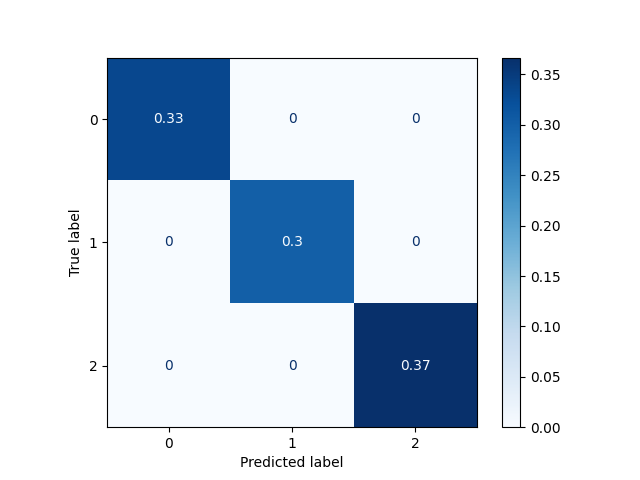

In [14]:
# Display HTML output artifacts
from IPython.display import display, HTML
display(HTML(mlrun.get_dataitem(train_run.outputs['confusion-matrix']).get().decode('utf-8')))


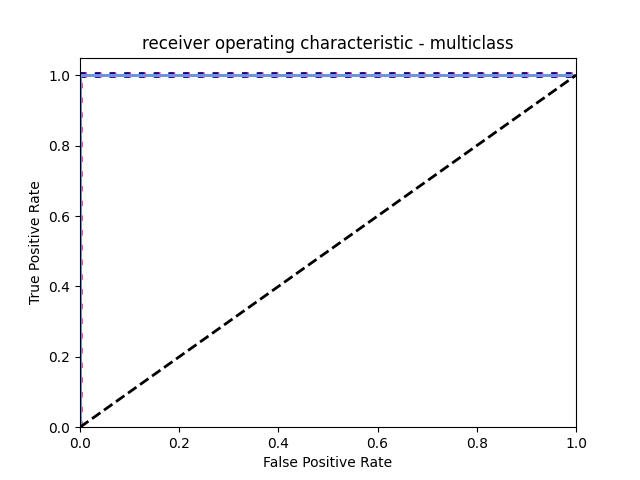

In [15]:
display(HTML(mlrun.get_dataitem(train_run.outputs['roc-multiclass']).get().decode('utf-8')))

<a id="gs-explore-data-w-pandas-df"></a>

### Exploring the Data with pandas DataFrames

Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [16]:
# Read your data set
df = mlrun.get_dataitem(train_run.outputs['test_set']).as_df()

In [17]:
# Display a portion of the read data
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,3.8,6.7,2.2,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


In [18]:
# Calculate and display the number of data-set items
print(f'Total number of rows: {len(df)}')

Total number of rows: 30


In [19]:
# Display statistics grouped by label
df.groupby(['label']).describe()

sepal length (cm)                                                  \
                  count      mean       std  min  25%   50%    75%  max   
label                                                                     
0                  10.0  5.070000  0.346570  4.7  4.8  4.95  5.325  5.7   
1                   9.0  6.011111  0.391933  5.6  5.7  6.00  6.200  6.8   
2                  11.0  6.690909  0.656437  5.8  6.3  6.50  6.950  7.9   

      sepal width (cm)            ... petal length (cm)      petal width (cm)  \
                 count      mean  ...               75%  max            count   
label                             ...                                           
0                 10.0  3.330000  ...               1.6  1.7             10.0   
1                  9.0  2.766667  ...               4.7  4.8              9.0   
2                 11.0  3.218182  ...               5.9  6.7             11.0   

                                                      
           mean       std  min   25%   50%  75%  max  
label                                                 
0      0.250000  0.108012  0.1  0.20  0.25  0.3  0.4  
1      1.344444  0.166667  1.1  1.20  1.30  1.5  1.6  
2      2.145455  0.269680  1.8  1.95  2.10  2.4  2.5  

[3 rows x 32 columns]

<a id="gs-tutorial-2-step-explore-data-w-mlrun-func"></a>

## Step 3: Exploring the Data with an MLRun Marketplace Function

You can perform further data exploration by leveraging **the MLRun functions marketplace** (a.k.a. "the MLRun functions hub").
This marketplace is a centralized location for open-source contributions of function components that are commonly used in machine-learning development.
The location of the marketplace is configured via the `hub_url` MLRun configuration.
By default, it points to the [mlrun/functions](https://github.com/mlrun/functions/) GitHub repository.
> **Note:** `hub_url` points to the raw GitHub URL, and can be defined with `{name}` and `{tag}` annotations, as done in the default value &mdash;
> `https://raw.githubusercontent.com/mlrun/functions/{tag}/{name}/function.yaml`.

This step uses the [`describe` marketplace function](https://github.com/mlrun/functions/tree/master/describe), which performs data exploration on a provided data set.
The function is used to extract information from your data set, analyze it, and visualize relevant information in different ways.

### Adding an Exploration Function

Use the `import_function` MLRun method, which adds or updates a function object in a project, to load the `describe` MLRun marketplace function into a new `describe` project function. 
The tutorial code sets the first `import_function` parameter &mdash; `url` &mdash; which identities the function to load.

> **Note:** MLRun supports multiple types of URL formats.
> The example uses the `hub://<function name>` format to point to the `describe` function-code directory in the MLRun functions marketplace (`'hub://describe'`).
> You can add `:<tag>` to this syntax to load a specific function tag &mdash; `hub://<function_name>:<tag>`; replace the `<function name>` and `<tag>` placeholders with the desired function name and tag.

In [20]:
from mlrun import mlconf
import os

mlconf.hub_url = os.getenv('LOCAL_HUB','https://raw.githubusercontent.com/mlrun/functions/{tag}/{name}/function.yaml')

In [21]:
describe = mlrun.import_function('hub://describe').apply(auto_mount())

<a id="gs-tutorial-2-view-func-doc"></a>

### Viewing the Function Documentation

Use the `doc` method to view the embedded documentation of the `describe` function.

In [22]:
describe.doc()

function: describe
describe and visualizes dataset stats
default handler: summarize
entry points:
  summarize: Summarize a table
    context(MLClientCtx)  - the function context, default=
    table(DataItem)  - MLRun input pointing to pandas dataframe (csv/parquet file path), default=
    label_column(str)  - ground truth column label, default=None
    class_labels(List[str])  - label for each class in tables and plots, default=[]
    plot_hist(bool)  - (True) set this to False for large tables, default=True
    plots_dest(str)  - destination folder of summary plots (relative to artifact_path), default=plots
    update_dataset  - when the table is a registered dataset update the charts in-place, default=False


### Running the Exploration Function

Run the following code to execute the `describe` project function as a Kubernetes job by using the MLRun `run` method.
The returned run object is stored in a `describe_run` variable.

The location of the data set is the only input that you need to provide.
This information is provided as a `table` input artifact that points to the `table_set` output artifact of the `train_run` job that you ran in the previous step.

In [23]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    train_run.outputs['test_set']})

> 2021-08-15 11:57:21,303 [info] starting run describe-summarize uid=7d1ca784e434436eba7b342be1305b25 DB=http://mlrun-api:8080
> 2021-08-15 11:57:21,511 [info] Job is running in the background, pod: describe-summarize-pbrxr
> 2021-08-15 11:57:32,181 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-edmond,...e1305b25,0,Aug 15 11:57:26,completed,describe-summarize,v3io_user=edmondkind=jobowner=edmondhost=describe-summarize-pbrxr,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 7d1ca784e434436eba7b342be1305b25 --project getting-started-tutorial-edmond , !mlrun logs 7d1ca784e434436eba7b342be1305b25 --project getting-started-tutorial-edmond
> 2021-08-15 11:57:40,759 [info] run executed, status=completed


### Reviewing the Run Output

The output cell for your code execution contains a run-information table.
You can also view run information in the MLRun dashboard; see the output-review information in Step 2, only this time look for the `describe-summarize` job and related artifacts.

The `describe` function generates three HTML output artifacts, which provide visual insights for your data set &mdash; `histograms`, `imbalance`, and `correlation`.
The artifacts are stored as HTML files in your project's artifacts directory, under **&lt;project artifacts path&gt;/jobs/plots/**.
The following code displays the artifact files in the notebook.


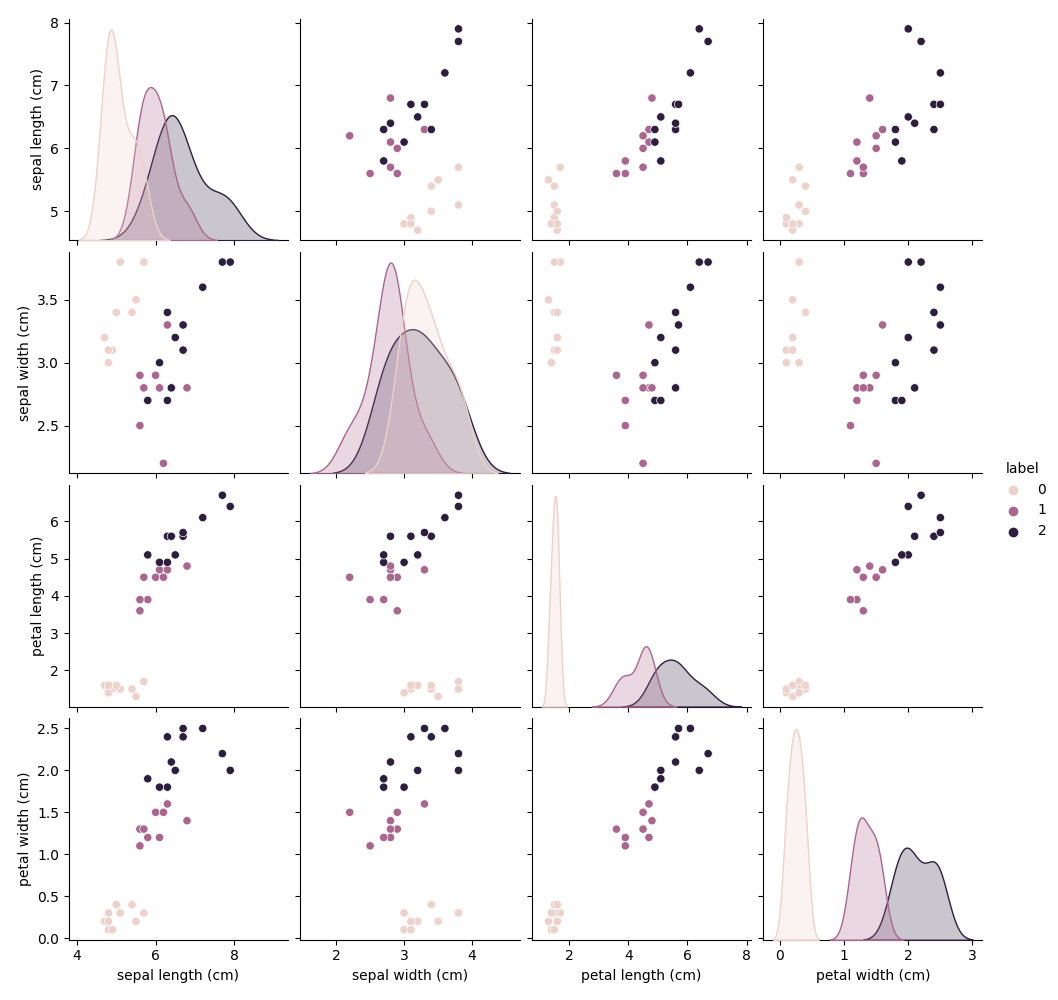

In [24]:
# Display the `histograms` artifact
display(HTML(mlrun.get_dataitem(describe_run.outputs['histograms']).get().decode('utf-8')))


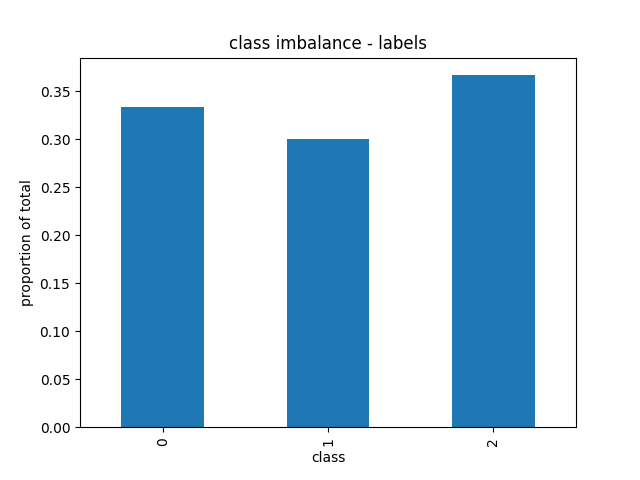

In [25]:
# Display the `imbalance` artifact
display(HTML(mlrun.get_dataitem(describe_run.outputs['imbalance']).get().decode('utf-8')))


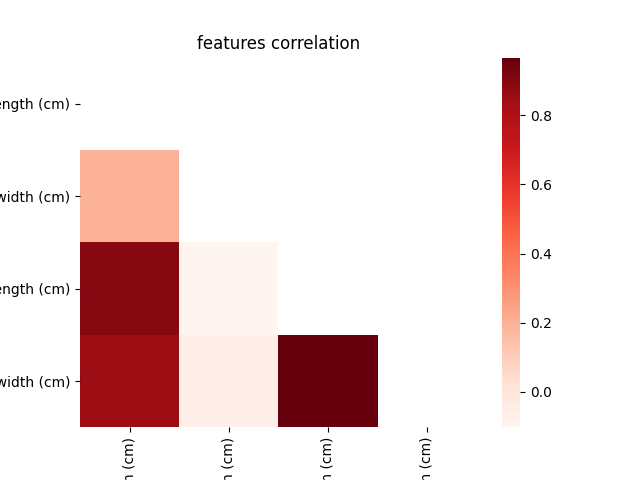

In [26]:
# Display the `correlation` artifact
display(HTML(mlrun.get_dataitem(describe_run.outputs['correlation']).get().decode('utf-8')))

<a id="gs-tutorial-2-step-test-model"></a>

## Step 4: Testing Your Model

Now that you have a trained model, you can test it:
run a task that uses the [`test_classifier` marketplace function](https://github.com/mlrun/functions/tree/master/test_classifier) to run the selected trained model against the test data set, as returned for the training task (`train`) in the previous step.

<a id="gs-tutorial-2-add-test-function"></a>

### Adding a Test Function

Run the following code to add to your project a `test` function that uses the `test_classifier` marketplace function code, and create a related `test` function object.

In [27]:
test = mlrun.import_function('hub://test_classifier').apply(auto_mount())

<a id="gs-tutorial-2-run-model-testing-job"></a>

### Running a Model-Testing Job

Configure parameters for the test function (`params`), and provide the selected trained model from the `train_run` job as an input artifact (`inputs`).

In [28]:
test_run = test.run(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']})

> 2021-08-15 11:57:50,364 [info] starting run test uid=ac9d06abd5114f5980cc163cb544bf9b DB=http://mlrun-api:8080
> 2021-08-15 11:57:50,555 [info] Job is running in the background, pod: test-qcwzk
> 2021-08-15 11:57:56,963 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-edmond,...b544bf9b,0,Aug 15 11:57:55,completed,test,v3io_user=edmondkind=jobowner=edmondhost=test-qcwzk,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,confusion-matrixprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run ac9d06abd5114f5980cc163cb544bf9b --project getting-started-tutorial-edmond , !mlrun logs ac9d06abd5114f5980cc163cb544bf9b --project getting-started-tutorial-edmond
> 2021-08-15 11:57:59,757 [info] run executed, status=completed


<a id="gs-test-model-run-output-review"></a>

### Reviewing the Run Output

Check the output information for your run in Jupyter Notebook and on the MLRun dashboard.

Use the following code to display information from the run object &mdash; the accuracy of the model, and the `confusion` and `roc` HTML output artifacts.

Test Accuracy: 1.0



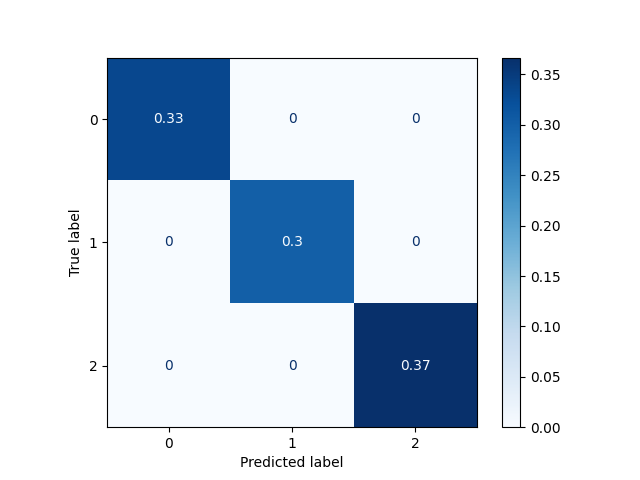


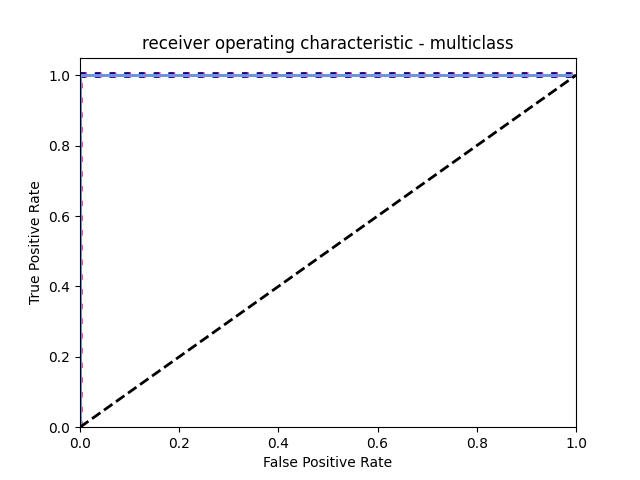

In [29]:
# Display the model accuracy
print(f'Test Accuracy: {test_run.outputs["accuracy"]}')

# Display HTML output artifacts
display(HTML(mlrun.get_dataitem(test_run.outputs['confusion-matrix']).get().decode('utf-8')))
display(HTML(mlrun.get_dataitem(test_run.outputs['roc-multiclass']).get().decode('utf-8')))

<a id="gs-tutorial-2-done"></a>

## Done!

Congratulation! You've completed Part 2 of the MLRun getting-started tutorial.
Proceed to [Part 3](03-model-serving.ipynb) to learn how to deploy and server your model using a serverless function.